<a href="https://colab.research.google.com/github/AhmadObeid/CRISPR-VAE/blob/main/CRISPR_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
from numpy.random import seed
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
import sys  

from tensorflow.keras import regularizers 
from sklearn import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras import layers, activations
import sys
import os
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from scipy.stats import spearmanr, norm
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, norm
import scipy.io as sio
import itertools
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle 
import time
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
import seaborn as sns
from itertools import combinations 
import pdb
from collections import defaultdict
import openpyxl
from openpyxl import Workbook
from openpyxl.styles import  Font, Color

Mounted at /content/drive/


# Utilities

Models

In [ ]:
def bld_seqDeepCpf(DO=0.3, optim='rmsprop',act='relu'):
    global num_classes
    mdl = tf.keras.Sequential([tf.keras.layers.Conv1D(80,5,activation=act,input_shape = (34,4),name='conv1'),
                                      tf.keras.layers.AveragePooling1D(2),                                      
                                      tf.keras.layers.Flatten(name='flat'),
                                      tf.keras.layers.Dense(80,activation=act,name='dense80'),                                                            
                                      tf.keras.layers.Dropout(DO,name='DO'),
                                      tf.keras.layers.Dense(40,activation=act,name='dense40'),
                                      tf.keras.layers.Dropout(DO),
                                      tf.keras.layers.Dense(40, activation=act,name='dense40_1'),
                                      tf.keras.layers.Dropout(DO),     
                                      tf.keras.layers.Dense(1,name='dense_last')])
    mdl.compile(optimizer=optim,loss='mse')
    return mdl

def build_classifier_cam(): 
    print("Building classifier")
    classifier = tf.keras.Sequential([tf.keras.layers.Conv2D(30,(5,1),activation='relu',input_shape = (31,4,1),
                                                             name='conv1'),
                                      tf.keras.layers.AveragePooling2D((2,1)),
                                      
                                      tf.keras.layers.Dropout(0.4),
                                      tf.keras.layers.Conv2D(30,(5,1),name='conv2'),
                                      tf.keras.layers.AveragePooling2D((2,1)),
                                      tf.keras.layers.Dropout(0.3),
                                      tf.keras.layers.Flatten(),                                      
                                      tf.keras.layers.Dense(1, activation='sigmoid')])
    return classifier

CRISPR-VAE essentials

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
    mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

class CustomVariationalLayer(keras.layers.Layer):    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean( 
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        # beta = inputs[2]
        loss = self.vae_loss(x, z_decoded) #, beta
        self.add_loss(loss, inputs=inputs)
        return x

def inject_T(decoded_seq):
  lb_temp = preprocessing.LabelBinarizer().fit(np.arange(4))
  injection = 3*np.ones((len(decoded_seq),))
  inj = lb_temp.transform(injection)[:,None,:]
  inj = np.repeat(inj,3,axis=1)
  inj.shape
  decoded_seq = np.concatenate((decoded_seq[:,:4,:,:],inj[:,:,:,None],decoded_seq[:,4:,:,:]),axis=1)
  return decoded_seq

def seq_to_txt_bulk(array):
  n = len(array)
  maxxed_array = array.argmax(-1)
  choice = np.array(["A","C","G","T"])
  str1 = ""
  txt_array = []
  for seq in range(n):
    temp = choice[maxxed_array[seq]]
    txt_array += [str1.join(temp)]  
  return txt_array

Miscellaneous 

In [ ]:
def seq_to_img(max_indices):
  digit_size = 24
  n = len(max_indices)
  figure = np.zeros((digit_size, digit_size * n,3))
  A = plt.imread("/content/drive/MyDrive/CRISPR-VAE/A.png")[:,:,:3]
  C = plt.imread("/content/drive/MyDrive/CRISPR-VAE/C.png")[:,:,:3]
  G = plt.imread("/content/drive/MyDrive/CRISPR-VAE/G.png")[:,:,:3]
  T = plt.imread("/content/drive/MyDrive/CRISPR-VAE/T.png")[:,:,:3]
  choice = (A,C,G,T)
  for bp in range(n):
    figure[:,bp*digit_size:(bp+1)*digit_size,:] = choice[max_indices[bp]]
  plt.figure(figsize=(10, 10))
  fig = plt.imshow(figure)
  plt.axis('off')
  return figure

def one_hot(array):
    max_idx = np.argmax(array,axis=1)
    one_hot_array = np.zeros(array.shape)
    one_hot_array[range(len(array)),max_idx] = 1
    return one_hot_array, max_idx

def one_hot_loading(lines):
    data_n = len(lines) - 1
    SEQ = np.zeros((data_n, 34, 4), dtype=float)
    rating = np.zeros((data_n, 1), dtype=int)
    for l in range(1, data_n+1):
        data = lines[l].split()
        seq = data[1]
        for i in range(34):
            if seq[i] in "Aa":
                SEQ[l-1, i, 0] = 1
            elif seq[i] in "Cc":
                SEQ[l-1, i, 1] = 1
            elif seq[i] in "Gg":
                SEQ[l-1, i, 2] = 1
            elif seq[i] in "Tt":
                SEQ[l-1, i, 3] = 1
        rating[l-1,0] = int(data[-1])
    return SEQ[:,:,:,None], rating

def load_data():  
  print("Loading HT1-1 data")
  FILE = open("/content/drive/MyDrive/CRISPR-VAE/Datasets/input_HT1-1-Rates-99.txt", "r") 
  data = FILE.readlines()
  SEQ11, Rates11 = one_hot_loading(data)  
  FILE.close()

  print("Loading HT1-2 data")
  FILE = open("/content/drive/MyDrive/CRISPR-VAE/Datasets/input_HT1-2-Rates-99.txt", "r")
  data = FILE.readlines()
  SEQ12, Rates12 = one_hot_loading(data)  
  FILE.close()

  print("Loading HT2 data")
  FILE = open("/content/drive/MyDrive/CRISPR-VAE/Datasets/input_HT2-Rates-99.txt", "r") 
  data = FILE.readlines()
  SEQ2, Rates2 = one_hot_loading(data)  
  FILE.close()

  print("Loading HT3 data")
  FILE = open("/content/drive/MyDrive/CRISPR-VAE/Datasets/input_HT3-Rates-99.txt", "r") 
  data = FILE.readlines()
  SEQ3, Rates3 = one_hot_loading(data)
  FILE.close()
  return SEQ11, SEQ12, SEQ2, SEQ3, Rates11, Rates12, Rates2, Rates3

def get_agreement(start,finish,choice='range'):
    clss = range(start,finish) if choice == 'range' else (start,finish)    
    deepCpf_pred = np.array([0])
    cvae_pred = np.array([0])
    for idx, cl in enumerate(clss): 
        preds = sio.loadmat('/content/drive/MyDrive/CRISPR-VAE/synthetic_'+str(cl)+'_pred.mat')['Rates_synth'].flatten()         
        deepCpf_pred = np.concatenate((deepCpf_pred,preds),axis=0)
        cvae_pred = np.concatenate((cvae_pred,idx*np.ones((10000,))),axis=0)
    deepCpf_pred = deepCpf_pred[1:]
    cvae_pred = cvae_pred[1:]
    c, _ = spearmanr(deepCpf_pred,cvae_pred)
    print('The agreement from a Spearman''s Correlation Coefficient sense is: {:.3f}'.format(c))

def conv(array=None, mask_size=None):
  w,h,d = array.shape
  mask = np.ones((mask_size,mask_size)).astype(bool)
  mid = int((mask_size-1)/2)
  mask[1:-1,1:-1] = False
  # mask[mid,mid] = -1
  out = np.zeros((h-2*mid,w-2*mid))
  for i in range(mid,h-mid):
    for j in range(mid,w-mid):
      patch = array[i-mid:i+mid+1,j-mid:j+mid+1,:]
      patch = patch[mask,:] 
      dist = []
      for neighbor in range(len(patch)):
        dist += [sum(patch[neighbor,:] != array[i,j,:])]
      out[i-mid,j-mid] = np.mean(np.array(dist))
  return out


Filtering and Feature Extraction

In [ ]:
def hist_mers(seqs=None,region='seed',k=3,save=0,location=None,bi=False,name=None):
    seqs = np.unique(seqs)
    regions = {
        'pre_pam':slice(0,4),
        'pam':slice(4,8),
        'psj':slice(7,9),
        'seed':slice(8,14), 
        'seed1':slice(8,11), #although it's 3, it works with 2-mer
        'seed2':slice(9,12),
        'seed3':slice(10,13),
        'seed4':slice(11,14),
        'seed5':slice(12,14), #specific for 2-mer 
        'stj':slice(13,15),
        'tr':slice(14,26),
        'tr1':slice(14,17),
        'tr2':slice(15,18),
        'tr3':slice(16,19),
        'tr4':slice(17,20),
        'tr5':slice(18,21),
        'tr6':slice(19,22),
        'tr7':slice(20,23),
        'tr8':slice(21,24),
        'tr9':slice(22,25),
        'tr10':slice(23,26),
        'tpj':slice(25,27),
        'prom':slice(26,31),
        'prom1':slice(26,29),
        'prom2':slice(27,30),
        'prom3':slice(28,31),
        'post_seq':slice(31,34),
        'whole':slice(0,34)
               }    
    
    mers = []  
    size = k #for saving only
    k = 4 if region == 'pam' or region == 'pre_pam' else k
    L = regions[region].stop - regions[region].start
    th = (len(seqs)*(L-k+1))/8.5
    for seq in list(seqs):
        wanted_reg = seq[regions[region]]        
        for i in range(L-k+1):
            mers += [wanted_reg[i:i+k]]
    
    plt.figure()
    a,b = np.unique(np.array(mers),return_index=True)
    b = np.sort(b)
    fig = plt.hist(np.array(mers),len(a))    
    n = 5 #max(sum(fig[0]>=th),5)        
    srt = np.argsort(-fig[0])[:n]     
    if save:
        plt.close('all')      
        
        saveat = '/content/drive/MyDrive/CRISPR-VAE/' + name + '_' + str(size) + 'mer.xlsx'
        if not os.path.exists(saveat):
            wb = Workbook()
            ws = wb.active
            ws.title = region
        else:
            wb = openpyxl.load_workbook(saveat)            
            ws = wb[region] if region in wb.sheetnames else wb.create_sheet(region)
        row = ws.max_row + 1    
        if location != None:
            txt = 'Samples taken from ({:.3f},{:.3f}) : ({:.3f},{:.3f})'.format(location[0],location[2],location[1],location[3]) 
            ws.cell(row,1,txt)
            row += 1
        ws.cell(row,1,'{} unique mers'.format(len(fig[0])))
        ws.cell(row,2,'max possible is {}'.format(4**k))
        row += 1        
        ws.cell(row,1,'Mer')        
        ws.cell(row,2,'Count')
        ws.cell(row,3,'Significance Thr. = {}'.format(th))
        row += 1
        
        for idx, s in enumerate(srt):
            ws.cell(idx+row,1,mers[b[s]])
            ws.cell(idx+row,2,fig[0][s])
        ws.cell(ws.max_row+1,1,'end')
        wb.save(saveat)
    else:
        plt.xticks(rotation = 45)      
        plt.title(str(k)+'-mer of '+region+' region')
        txt = 'number of unique\nmers is: '+str(len(fig[0]))
        poss = (L-k + 1)*len(seqs)
        txt2 = ''
        for i in srt:
            txt2 += '\n'+mers[b[i]]    
        txt += txt2
        txt += '\n'+str(poss)+' sampled sequences'
        plt.text(fig[1][int(len(fig)/2)],int(max(fig[0])/2),txt)   
        plt.show()

def get_region_2d(args,extent):
    min1,max1,min2,max2 = args
    n = len(extent)
    grid = np.meshgrid(extent,extent)
    flat_grid = np.reshape(grid,(2,n**2))
    idx_min1, idx_max1 = np.where(flat_grid[0]>=min1)[0], np.where(flat_grid[0]<=max1)[0]
    
    range1 = np.intersect1d(idx_min1,idx_max1)
    idx_min2, idx_max2 = np.where(flat_grid[1]>=min2)[0], np.where(flat_grid[1]<=max2)[0]
    
    range2 = np.intersect1d(idx_min2,idx_max2)
    
     
   
    total_range = np.intersect1d(range1,range2)
    region = flat_grid[:,total_range]
    
    return region, total_range

class filter_feats(): #colors the significant in red
    def __init__(self,mer_size):
        self.ft_sig = Font(color="00FF0000")        
        self.high_file = '/content/drive/MyDrive/CRISPR-VAE/synth99_'+str(mer_size)+'mer'
        self.low_file = '/content/drive/MyDrive/CRISPR-VAE/synth0_'+str(mer_size)+'mer'
        self.wb_high = openpyxl.load_workbook(self.high_file+'.xlsx')
        self.wb_low = openpyxl.load_workbook(self.low_file+'.xlsx')
        self.significant = {'Location0':{},'Location1':{},
                            'Location2':{},'Location3':{},
                            'Location4':{}}        
        
    def in_high(self,for_pvals=False):                         
        for sheet in self.wb_high.sheetnames:
            if sheet == 'pam' or sheet=='pre_pam' or sheet=='post_seq': continue
            self.ws_high= self.wb_high[sheet]           
            for idx, Location_high in enumerate([14,23,32,41,5]):  #go to each Location in high        
                th_high = float(self.ws_high[Location_high-1][2].value.split()[-1])            
                for row in range(5): #go to all 5 sequences of each Location 
                                     
                    cnt = self.ws_high[Location_high+row][1].value 
                    high_seq = self.ws_high[Location_high+row][0].value
                    if cnt > th_high:
                        exists = self.in_low(high_seq,sheet,Location_high+row)
                        if not exists:
                            self.ws_high[Location_high+row][0].font = self.ft_sig                              
                            self.significant['Location'+str(idx)][sheet+' '+high_seq] = cnt if for_pvals else cnt/th_high
                        
        self.wb_high.save(self.high_file+'.xlsx')   
        return self.significant
        
        
    def in_low(self,high_seq,sheetname,placement):
        ws_low = self.wb_low[sheetname]        
        for Location_low in [5,14,23,32,41]: #go to each Location in low
            th_low = float(ws_low[Location_low-1][2].value.split()[-1])    
            for row in range(5):
                if ws_low[Location_low+row][0].value == high_seq and ws_low[Location_low+row][1].value > th_low:                    
                    return True
        else: return False

def draw_significant_feats(dic,circular=False,specials=None,for_pvals=False):             
    mrk = "$\checkmark$"  
    specials_ult = defaultdict(list) #the special cases, if they're significant in the synthetic data
    if for_pvals:
        region_return, mers_return, counts_return = [], [], []        
    for location_idx, Location in enumerate(dic): #one separate drawing for each region
        x, y, sub_x = [], [], []
        for entry in range(len(dic[Location].keys())):
           if circular:
               x += [list(dic[Location].keys())[entry].split()[0][0]]
               sub_x += [list(dic[Location].keys())[entry].split()[0][-1]]
           else:
               x += [list(dic[Location].keys())[entry].split()[0]] 
           
           y += [list(dic[Location].keys())[entry].split()[1]]
           
        levels = list(dic[Location].values())
        un_y, un_idx = np.unique(y,return_index=True)
        if circular:            
            both = []            
            for  pair in zip(x,sub_x):
                both += ["".join(pair)]
            theta = np.linspace(0,2*np.pi-2*np.pi/17,17)+2*np.pi/(2*17)
            poss = ['s1','s2','s3','s4',
                             't1','t2','t3','t4','t5',
                             't6','t7','t8','t9','t0', #t0 = t10
                             'p1','p2','p3'] 
            if for_pvals:
                region_return += [both]
                mers_return += [y]
                counts_return += [levels]
                
            else: #don't need any of this for p_vals, except specials_ult   
                plt.figure()
                angles = {}
                for idx, pos in enumerate(poss):
                    angles[pos] = theta[idx]
                colors = {'s':'r','t':'g','p':'b'}                   
                
                levels = np.array(levels)  
                mx = 1.1*max(levels)            
                #xs, ys = (mx-levels)*np.cos(theta), (mx-levels)*np.sin(theta)
                xs, ys = [], []
                for idx, case in enumerate(both):                    
                    xs += [(mx-levels[idx])*np.cos(angles[case])]
                    ys += [(mx-levels[idx])*np.sin(angles[case])]
                
                plt.scatter(xs,ys,marker='.',c='k') 
                
                srt_lv = np.sort(levels)             
                rings = mx-[srt_lv[0],srt_lv[int(len(levels)/2)],srt_lv[-2]]
                rings_vals = mx-[srt_lv[0],srt_lv[int(len(levels)/2)],srt_lv[-1]]
                rho = np.arange(0,np.pi*2,0.01)
                sig_txt_loc = 110 * np.pi/180
            
                for ring_idx, ring in enumerate(rings):
                    plt.plot(ring*np.cos(rho),ring*np.sin(rho),c='k',linewidth=0.5)                 
                    plt.text(ring*np.cos(sig_txt_loc),ring*np.sin(sig_txt_loc),
                              '{:.2f}'.format(mx-rings_vals[ring_idx]),
                              rotation=0,weight='bold',fontsize=13) #significance text          
                
                plt.axis('off')
            for idx,mer in enumerate(y): 
                if not for_pvals:                            
                    plt.text(xs[idx],ys[idx],mer,fontsize=17,c=colors[x[idx]])
                if mer in specials[both[idx]] and location_idx<4:
                    specials_ult[both[idx]] += [mer]
                    if not for_pvals:
                        plt.plot(xs[idx],ys[idx],marker=mrk,
                                  markersize=20,c=colors[x[idx]]) #for checkmarks
                        # plt.plot(0.03*max(levels)*np.cos(rho)+xs[idx],
                        #          0.03*max(levels)*np.sin(rho)+ys[idx],c=colors[x[idx]])
                
            if not for_pvals:
                for idx, ang in enumerate(theta - 2*np.pi/(2*17)):
                    if idx not in [2,5,6,8,9,10,12,13]: #unwanted lines
                        ang_x, ang_y = np.cos(ang), np.sin(ang)
                        if idx in [0,4,14]:
                            r = np.linspace(0,max(rings_vals),100) 
                            plt.plot(r*ang_x,r*ang_y,'k')
                        else:                        
                            r = np.linspace(0,max(rings_vals),100)
                            plt.plot(r*ang_x,r*ang_y,'k--')
        else:
            plt.scatter(x,levels,c='w')        
            plt.xticks(rotation = 45,fontsize=15) 
            plt.yticks(fontsize=17) 
            
            plt.ylabel('Mer count / significance threshold',fontsize=17)
            for idx, level in enumerate(levels):            
                plt.text(x[idx],level,y[idx],fontsize=17)
        
    if for_pvals:
        return region_return, mers_return, counts_return, specials_ult

def collaps_special(specials):
    specials.pop('post_seq', None)    
    special_temp = {'s1':[],'s2':[],'s3':[],'s4':[],
                    't1':[],'t2':[],'t3':[],'t4':[],'t5':[],
                    't6':[],'t7':[],'t8':[],'t9':[],'t0':[],
                    'p1':[],'p2':[],'p3':[]}
    for entry in list(specials):   
        special_temp[entry[0]+entry[-1]] += specials[entry]
    return special_temp

def missed_out(mer_size): #highlights phenomena in HT3, HT2 that are likely to be missed by HT1
    ft = Font(color="000000FF")    
    high_file = '/content/drive/MyDrive/CRISPR-VAE/HT_high_'+str(mer_size)+'mer'
    low_file = '/content/drive/MyDrive/CRISPR-VAE/HT_low_'+str(mer_size)+'mer'
    wb_high = openpyxl.load_workbook(high_file+'.xlsx')
    wb_low = openpyxl.load_workbook(low_file+'.xlsx')
    for sheet in wb_high.sheetnames[1:]: #no need for pam
        ws_high, ws_low = wb_high[sheet], wb_low[sheet]
        HT1seqs_high, HT1seqs_low = [], []
        for row in range(4,9):
            HT1seqs_high += [ws_high[row][0].value]
            HT1seqs_low += [ws_low[row][0].value]
        HT1seqs_high, HT1seqs_low = np.unique(HT1seqs_high), np.unique(HT1seqs_low)
        for _,row in enumerate(list(range(20,25)) + list(range(12,17))):
            if ws_high[row][0].value not in HT1seqs_high:
                ws_high[row][0].font = ft
            if ws_low[row][0].value not in HT1seqs_low:
                ws_low[row][0].font = ft
    wb_high.save(high_file+'.xlsx')   
    wb_low.save(low_file+'.xlsx')

def highlight(mer_size): #highlights missed phenomena, revealed by synth data
    specials = {}
    ft = Font(color="00FF00FF")
    high_file = '/content/drive/MyDrive/CRISPR-VAE/HT_high_'+str(mer_size)+'mer'
    low_file = '/content/drive/MyDrive/CRISPR-VAE/HT_low_'+str(mer_size)+'mer'
    high_synth = '/content/drive/MyDrive/CRISPR-VAE/synth99_'+str(mer_size)+'mer'
    low_synth = '/content/drive/MyDrive/CRISPR-VAE/synth0_'+str(mer_size)+'mer'
    wb_high = openpyxl.load_workbook(high_file+'.xlsx')
    wb_low = openpyxl.load_workbook(low_file+'.xlsx')
    wb_synth_high = openpyxl.load_workbook(high_synth+'.xlsx')
    wb_synth_low = openpyxl.load_workbook(low_synth+'.xlsx')
    for sheet in wb_high.sheetnames: 
        if sheet=='pam' or sheet=='pre_pam':continue #no need for pam
        specials[sheet] = []
        ws_high, ws_low = wb_high[sheet], wb_low[sheet]
        ws_synth_high, ws_synth_low = wb_synth_high[sheet], wb_synth_low[sheet]
        synth_high_seqs, synth_low_seqs = [], []
        for _,row in enumerate(list(range(14,19))+list(range(23,28))+list(range(32,37))+list(range(41,46))):
            synth_high_seqs += [ws_synth_high[row][0].value]
            synth_low_seqs += [ws_synth_low[row][0].value]
        
        synth_high_seqs, synth_low_seqs = np.unique(synth_high_seqs), np.unique(synth_low_seqs)
        for _,row in enumerate(list(range(20,25)) + list(range(12,17))):
            
            if ws_high[row][0].value in synth_high_seqs and ws_high[row][0].font.color.value == '000000FF':
                ws_high[row][0].font = ft
                specials[sheet] += [ws_high[row][0].value]
            if ws_low[row][0].value in synth_low_seqs and ws_low[row][0].font.color.value == '000000FF':
                ws_low[row][0].font = ft
    wb_high.save(high_file+'.xlsx')   
    wb_low.save(low_file+'.xlsx')
    return specials



# Data Loading

In [ ]:
#Get HT1-1, HT1-2, HT1, HT3
SEQ11, SEQ12, SEQ2, SEQ3, Rates11, Rates12, Rates2, Rates3 = load_data()
num_classes = len(np.unique(Rates11))
#Combine HT1-1 and HT1-2 to get HT1
SEQ1, Rates1 = np.concatenate((SEQ11,SEQ12),axis=0), np.concatenate((Rates11,Rates12),axis=0)
lb = preprocessing.LabelBinarizer().fit(Rates1)
Rates1, Rates2, Rates3 = lb.transform(Rates1), lb.transform(Rates2), lb.transform(Rates3)

#Removing TTT in PAM, important as CRISPR-VAE was trained as such
SEQ1_nopam = np.concatenate((SEQ1[:,:4,:,:],SEQ1[:,7:,:,:]),axis=1)

Loading HT1-1 data
Loading HT1-2 data
Loading HT2 data
Loading HT3 data


# CRISPR-VAE Initialization

In [ ]:
seq_shape =  (31,4,1) 
batch_size = 512
latent_dim = 2


input_seq = keras.Input(shape=seq_shape)
x = layers.Conv2D(80, (5,1),activation='relu')(input_seq)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.0)(x)


dense1 = layers.Dense(80,activation='relu')
x = dense1(x)
x = layers.Dropout(0.0)(x)

condition_shape = (num_classes) 
input_condition = keras.Input(shape=condition_shape)
x = tf.keras.layers.concatenate([x, input_condition], axis=-1)

dense2 = layers.Dense(40,activation='relu')
x = dense2(x)
x = layers.Dropout(0.0)(x)

dense2_2 = layers.Dense(40,activation='relu')
x = dense2_2(x)
x = layers.Dropout(0.0)(x)

dense3 = layers.Dense(latent_dim)
z_mean = dense3(x)
z_log_var = layers.Dense(latent_dim)(x)


z = layers.Lambda(sampling)([z_mean, z_log_var])
decoder_input = layers.Input((latent_dim+num_classes))

x = layers.Dense(40,activation='relu')(decoder_input)
x = layers.Dense(40,activation='relu')(x)
x = layers.Dense(80,activation='relu')(x)
x = layers.Dense(np.prod(shape_before_flattening[1:]),activation='relu')(x)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(1, (5,1),activation='sigmoid')(x)


decoder = Model(decoder_input, x)
z = tf.keras.layers.concatenate([z, input_condition], axis=-1)
z_decoded = decoder(z)

y = CustomVariationalLayer()([input_seq, z_decoded])
vae = Model([input_seq,input_condition], y)

vae.compile(optimizer='adam',loss=None)

vae.load_weights('/content/drive/MyDrive/CRISPR-VAE/cvae_latest.h5')
decoder.load_weights('/content/drive/MyDrive/CRISPR-VAE/cvae_dec_latest.h5')

# seq-DeepCpf1 Initialization

In [ ]:
seqDeepCpf = bld_seqDeepCpf()
seqDeepCpf.load_weights('/content/drive/MyDrive/CRISPR-VAE/Rgs.h5')

# Decoder Visualization

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Text(0.5, 1.0, 'Original')

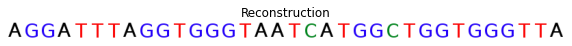

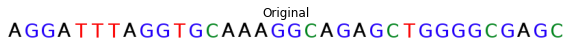

In [ ]:
from tensorflow.keras import models
latent_output =  vae.layers[-3].output 
latent_mdl = models.Model(inputs=vae.input, outputs=latent_output)
latent_code = latent_mdl.predict([SEQ1_nopam,Rates1])

decoded_output = decoder.layers[-1].output
decoder_mdl = models.Model(inputs=decoder.input, outputs=decoded_output)
decoded_seq = decoder_mdl.predict(latent_code)

decoded_seq = inject_T(decoded_seq) #Get TTT in PAM  
_, decoded_idx = one_hot(decoded_seq[879, :, :, 0]) # / #879 chosen at random, pick any other number at will
fig1 = seq_to_img(decoded_idx) 
plt.title('Reconstruction')
_, input_idx = one_hot(SEQ1[879, :, :, 0]) #879 chosen at random, pick any other number at will
fig2 = seq_to_img(input_idx)
plt.title('Original')

# Optional: Generating Synthetic Data + Labeling by seqDeepCpf1

This is optional, as the synthetic data generated for the paper is provided

In [ ]:
lb2 = preprocessing.LabelBinarizer().fit(np.arange(4))
grid_size = 100
dims = 2
clss = [0,99] 

for cls in clss:
  decoder_mdl = models.Model(inputs=decoder.input, outputs=decoded_output)
  extent = norm.ppf(np.linspace(0.05, 0.95,grid_size),scale=1)

  n = grid_size**dims 
  grid = np.meshgrid(extent,extent) #for 2D

  flat_grid = np.reshape(grid,(dims,grid_size**dims))
  flat_grid = flat_grid.transpose()

  conditions = np.repeat(lb.transform(np.array([cls,])),n,axis=0)
  flat_grid = np.concatenate((flat_grid,conditions),axis=1) 
  decoded_seq = decoder_mdl.predict(flat_grid)  

  decoded_seq = inject_T(decoded_seq) 
  txt_array = np.array(seq_to_txt_bulk(decoded_seq.squeeze())) 
  tmp = decoded_seq.squeeze().argmax(-1).flatten()
  tmp = lb2.transform(tmp)  
  decoded_seq = np.reshape(tmp,(n,34,4))
  Rates_synth = seqDeepCpf.predict(decoded_seq)

  # sio.savemat('/content/drive/MyDrive/CRISPR-VAE/synthetic_'+str(cls)+'_efficiency.mat',{'decoded_seq':decoded_seq}) #one-hot encoded
  # sio.savemat('/content/drive/MyDrive/CRISPR-VAE/synthetic_'+str(cls)+'_efficiency_txt.mat',{'txt_array':txt_array}) #strings
  # sio.savemat('/content/drive/MyDrive/CRISPR-VAE/synthetic_'+str(cls)+'_efficiency_labels.mat',{'Rates_synth':Rates_synth}) #Labels

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


# Agreement Testing

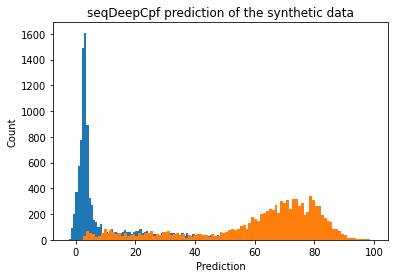

The agreement from a Spearmans Correlation Coefficient sense is: 0.796


In [ ]:
clss = [0,99] 
for cls in clss:
  Rates = sio.loadmat('/content/drive/MyDrive/CRISPR-VAE/synthetic_'+str(cls)+'_pred.mat')['Rates_synth']
  plt.hist(Rates,bins=100)
plt.title('seqDeepCpf prediction of the synthetic data')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()
get_agreement(0,99,None)


# Structure Confirmation

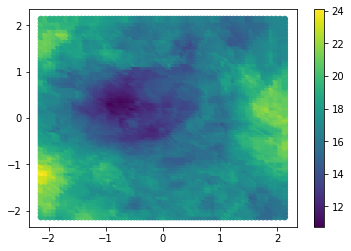

In [ ]:
n = 100
decoded_seq = sio.loadmat('/content/drive/MyDrive/CRISPR-VAE/synthetic_99_pred.mat')['decoded_seq']
seqs_num_encode = decoded_seq.argmax(-1)
seqs_num_encode = np.reshape(seqs_num_encode,(n,n,34))

m = [3,11,29]
mid_last = int((m[-1]-1)/2)
out = np.zeros((n-2*mid_last,n-2*mid_last,3))
for idx, i in enumerate(m):
  mid = int((i-1)/2)
  temp = conv(seqs_num_encode,i)
  if mid != mid_last:
    out[:,:,idx] = temp[mid_last-mid:-(mid_last-mid),mid_last-mid:-(mid_last-mid)]
  else:
    out[:,:,idx] = temp

extent = norm.ppf(np.linspace(0.05, 0.95,100),scale=2.3)[mid:-mid]
grid = np.meshgrid(extent,extent)
plt.scatter(grid[0],grid[1],c=out[:,:,2]) #choose out[:,:,lambda] to specify which lambda you want to view
plt.colorbar()

# Method 1 for Feature Extraction

In [ ]:
wanted_region = ['pre_pam','pam', 'seed1','seed2','seed3','seed4',
              'tr1','tr2','tr3','tr4','tr5','tr6','tr7','tr8','tr9','tr10',
              'prom1','prom2','prom3','post_seq']

1.   Histogram-summarize HT1, HT2, HT3

In [ ]:
files = ['HT1','HT2','HT3']
choice = ['high','low']
for fil in files:
    for idx,_ in enumerate(choice):
      seqs_str = sio.loadmat('/content/drive/MyDrive/CRISPR-VAE/'+fil+'_text.mat')['txt_array']
      freq = sio.loadmat('/content/drive/MyDrive/CRISPR-VAE/'+fil+'_text.mat')['freq']
      seqs_wanted = seqs_str[freq>75] if choice[idx] == 'high' else seqs_str[freq<25]
      mer_size = 3
      for region in wanted_region:
          hist_mers(seqs_wanted,region,k=mer_size,save=1,location=None,name='HT_'+choice[idx]) #


2.   Histogram-summarize the synthetic data


In [ ]:
n = 100 #number of points in each axis of the grid
extent = norm.ppf(np.linspace(0.05, 0.95,n),scale=1)
for cls in clss:
  seqs_str = sio.loadmat('/content/drive/MyDrive/CRISPR-VAE/synthetic_'+str(cls)+'_txt.mat')['txt_array']
  #For non-quadrant-based:
  location = (extent[0],extent[-1],extent[0],extent[-1])     
  region, wanted_location = get_region_2d(location,extent)   
  wanted_seqs = seqs_str[wanted_location]
  mer_size = 3
  for region in wanted_region:
              hist_mers(wanted_seqs,region,k=mer_size,save=1,location=location,name='synth'+str(cls))                
      
  #For quadrant-based   
  ends = [extent[0],0]
  for x in ends:
      x1 = x + extent[-1]
      for y in ends:            
          y1 = y + extent[-1]
          location = (x,x1,y,y1)  
          region, wanted_location = get_region_2d(location,extent) 
          wanted_seqs = seqs_str[wanted_location]    
          for region in wanted_region:
              hist_mers(wanted_seqs,region,k=mer_size,save=1,location=location,name='synth'+str(cls))


3.   Filtering + MSMs



In [ ]:
missed_out(3) #colors what exists in HT2, HT3, and not HT1 in blue
specials = highlight(3) #colors what's in blue in pink, if exists in synthetic data
specials = collaps_special(specials)
dic = filter_feats(3).in_high() #colors what's above the threshold by red
draw_significant_feats(dic,circular=True,specials=specials) #Gets the MSMs

# Note: if filter_feats()  back empty, this naturally throws an error when drawing the MSMs. 
# This usually happens with the non-quadrant-based MSM. Nevertheless, the other MSMs
# will have been drawn 

# Method 2 for Feature Extraction

1.   Get the synthetic data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 
SEQ_1 = sio.loadmat('/content/drive/MyDrive/CRISPR-VAE/synthetic_99_.mat')['decoded_seq']  
SEQ_1_str = sio.loadmat('/content/drive/MyDrive/CRISPR-VAE/synthetic_99_txt.mat')['txt_array'] 
_, a = np.unique(SEQ_1_str,return_index=True)
SEQ_1_unique, SEQ_1_str_unique = SEQ_1[a], SEQ_1_str[a]

SEQ_0 = sio.loadmat('/content/drive/MyDrive/CRISPR-VAE/synthetic_0_.mat')['decoded_seq']  

SEQ_0_str = sio.loadmat('/content/drive/MyDrive/CRISPR-VAE/synthetic_0_txt.mat')['txt_array']  
_, b = np.unique(SEQ_0_str,return_index=True)
SEQ_0_unique, SEQ_0_str_unique = SEQ_0[b], SEQ_0_str[b]

x, x_str = np.concatenate((SEQ_0_unique,SEQ_1_unique),axis=0), np.concatenate((SEQ_0_str_unique,SEQ_1_str_unique),axis=0)
y = np.concatenate((np.zeros(len(SEQ_0_unique),),np.ones(len(SEQ_1_unique),)),axis=0)
x, x_str, y = shuffle(x,x_str,y,random_state=123)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33)

x_train_noPAM = np.concatenate((x_train[:,:4,:],x_train[:,7:,:]),axis=1)
x_test_noPAM = np.concatenate((x_test[:,:4,:],x_test[:,7:,:]),axis=1)


2.   Train binary classifier

In [ ]:
classifier = build_classifier_cam()
classifier.compile('adam',loss='binary_crossentropy',metrics=['acc'])
classifier.fit(x_train_noPAM[...,None],y_train,
               epochs=10,verbose=1,
               validation_data=(x_test_noPAM[...,None],y_test))

Building classifier
Train on 8048 samples, validate on 3965 samples
Epoch 1/10
7936/8048 [============================>.] - ETA: 0s - loss: 0.3609 - acc: 0.8449

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


8048/8048 [==============================] - 2s 295us/sample - loss: 0.3595 - acc: 0.8452 - val_loss: 0.2284 - val_acc: 0.9064
Epoch 2/10
8048/8048 [==============================] - 2s 248us/sample - loss: 0.2064 - acc: 0.9184 - val_loss: 0.1587 - val_acc: 0.9440
Epoch 3/10
8048/8048 [==============================] - 2s 245us/sample - loss: 0.1665 - acc: 0.9349 - val_loss: 0.1334 - val_acc: 0.9501
Epoch 4/10
8048/8048 [==============================] - 2s 250us/sample - loss: 0.1466 - acc: 0.9431 - val_loss: 0.1200 - val_acc: 0.9556
Epoch 5/10
8048/8048 [==============================] - 2s 252us/sample - loss: 0.1286 - acc: 0.9520 - val_loss: 0.1035 - val_acc: 0.9602
Epoch 6/10
8048/8048 [==============================] - 2s 249us/sample - loss: 0.1091 - acc: 0.9594 - val_loss: 0.0925 - val_acc: 0.9644
Epoch 7/10
8048/8048 [==============================] - 2s 250us/sample - loss: 0.1085 - acc: 0.9585 - val_loss: 0.0822 - val_acc: 0.9695
Epoch 8/10
8048/8048 [=======================


3.   Prepare CAM model



In [ ]:
output = classifier.output[:,0]
last_conv_layer = classifier.get_layer('conv2')
grads = K.gradients(output,last_conv_layer.output)[0]
pooled_grads = K.mean(grads,axis=(0,1,2))
iterate = K.function([classifier.input],[pooled_grads, last_conv_layer.output[0]])


4.   Get the CAMs

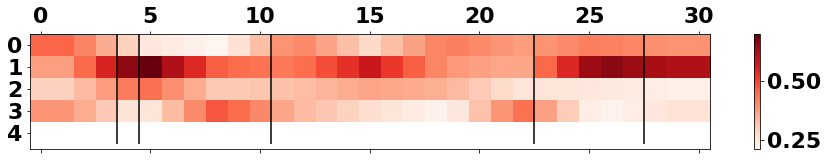

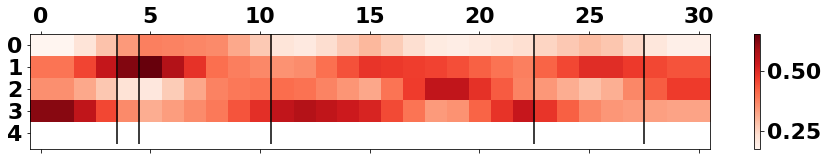

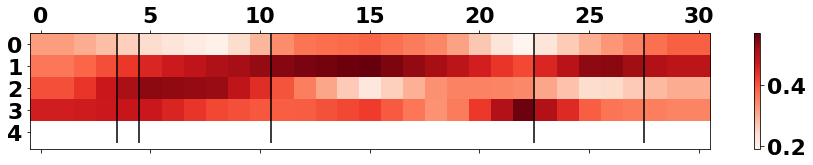

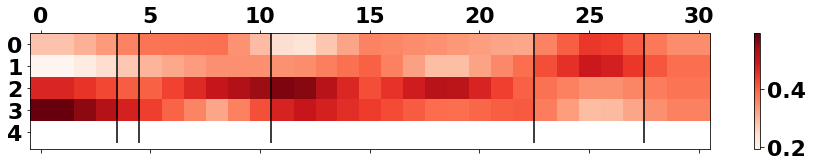

In [ ]:
import cv2
import matplotlib
for x in ends:
    x1 = x + extent[-1]
    for y in ends:            
        y1 = y + extent[-1]
        location = (x,x1,y,y1)  
        region, wanted_location = get_region_2d(location,extent) 
        wanted_seqs = SEQ_1[wanted_location]
        wanted_seqs = np.concatenate((wanted_seqs[:,:4,:],wanted_seqs[:,7:,:]),axis=1) #for without the PAM

        all = []
        for idx, seq in enumerate(wanted_seqs):  
          pooled_grads_value, conv_layer_output_value = iterate([seq[None,:,:,None]]) 
          conv_layer_output_value *= pooled_grads_value
          heatmap = np.mean(conv_layer_output_value, axis=-1)
          heatmap = np.maximum(heatmap, 0)
          heatmap /= np.max(heatmap)
          heatmap= cv2.resize(heatmap, (4, 31)) 
          superimposed_img = heatmap * 0.4 + seq
          if len(np.argwhere(np.isnan(heatmap))) > 0: continue
          all += [heatmap]
        all = np.array(all)        
        avg = np.mean(all,axis=0)

        font = {'family' : 'normal',
                'weight' : 'bold',
                'size'   : 22}        
        plt.matshow(avg.transpose(),cmap='Reds')
        plt.vlines([3.5,4.5,10.5,22.5,27.5],[-0.5,-0.5,-0.5,-0.5,-0.5],[4.5,4.5,4.5,4.5,4.5])
        plt.colorbar()    
        matplotlib.rc('font', **font)

